# 2.0 Model

## Simple set up

In [1]:
%run 0.2-jvs-before_to_start.ipynb

## Import libraries

In [2]:
import janitor
import shap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_flavor as pf
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    ShuffleSplit
)

## Set plot defaults

In [3]:
plt.style.use("seaborn")
sns.set_style("whitegrid")

## Load data

In [4]:
titanic_dfs = {
    f"{file.stem}": pd.read_csv(filepath_or_buffer=file)
    for file in data_processed_dir().glob("*.csv")
}

[display(df_name, df.head(2)) for df_name, df in titanic_dfs.items()];
locals().update(titanic_dfs)

'titanic_gender_submission_df'

,passenger_id,survived
0,892,0
1,893,1


'titanic_test_df'

,passenger_id,pclass,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


'titanic_train_df'

,passenger_id,survived,pclass,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## Prepare data

In [5]:
titanic_proccessed = (
    titanic_train_df
    .remove_columns(["passenger_id"])
    .select_columns([pd.api.types.is_numeric_dtype, "sex", "embarked"])
    .transform_columns(
        column_names=["sex", "embarked"],
        function=lambda column: column.factorize()[0],
        elementwise=False
    )
    .dropna()
)

titanic_proccessed

,survived,pclass,age,sib_sp,parch,fare,sex,embarked
0,0,3,22.0,1,0,7.2500,0,0
1,1,1,38.0,1,0,71.2833,1,1
2,1,3,26.0,0,0,7.9250,1,0
3,1,1,35.0,1,0,53.1000,1,0
4,0,3,35.0,0,0,8.0500,0,0
...,...,...,...,...,...,...,...,...
885,0,3,39.0,0,5,29.1250,1,2
886,0,2,27.0,0,0,13.0000,0,0
887,1,1,19.0,0,0,30.0000,1,0
889,1,1,26.0,0,0,30.0000,0,1


## Modelling

### Splitting data

In [6]:
X, y = titanic_proccessed.get_features_targets(target_column_names="survived")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
cv_train = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

### Create model

In [7]:
xgb_model = (
    xgb.XGBClassifier(
        objective="binary:hinge",
        eval_metric="error",
        random_state=0,
        use_label_encoder=False
    )
    .fit(X_train, y_train)
)

## Model visualization

### XGB

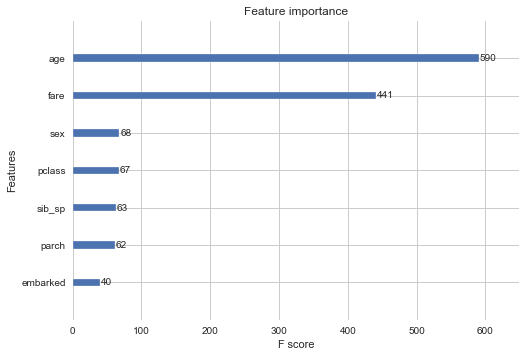

In [8]:
xgb.plot_importance(xgb_model);

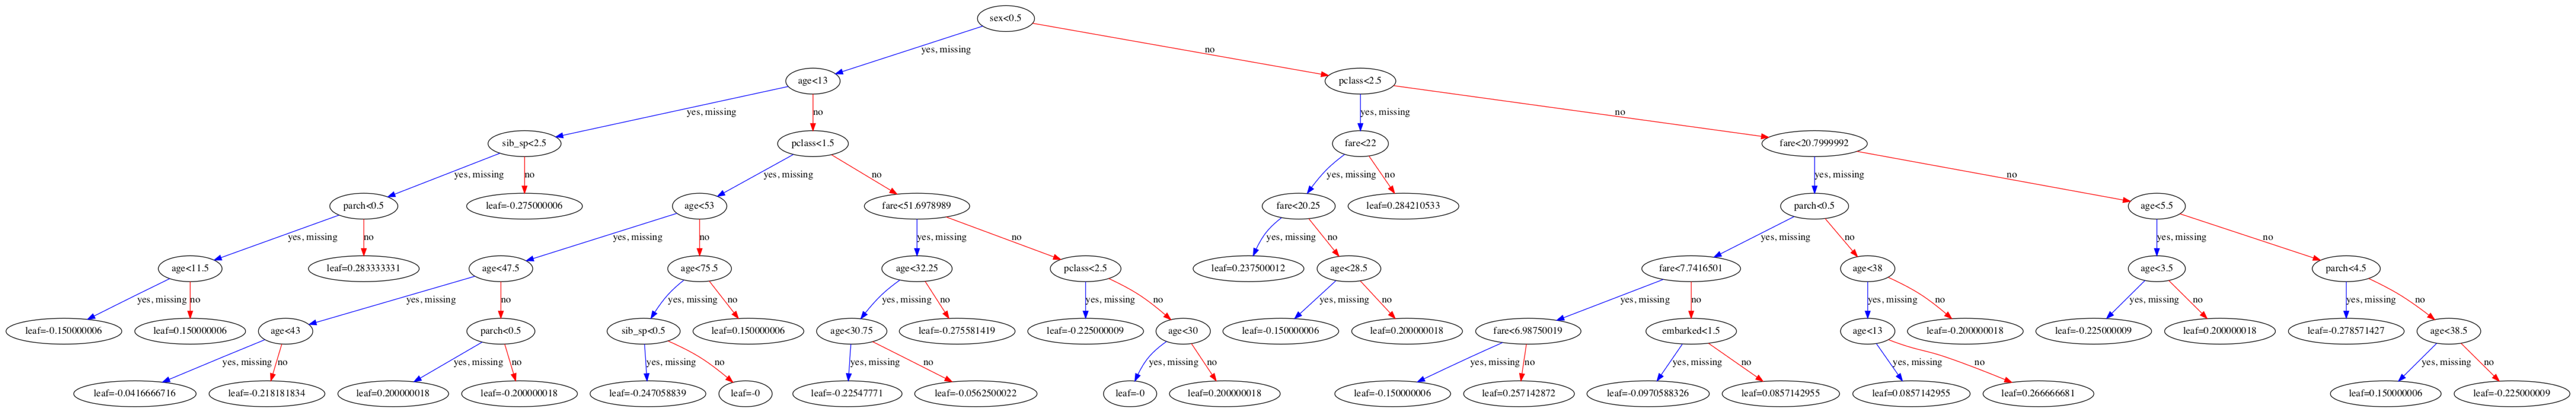

In [9]:
fig = plt.figure(figsize=(100, 100))
axes = fig.add_subplot(111)
xgb.plot_tree(xgb_model, ax=axes);

### SHAP (SHapley Additive exPlanations)

In [10]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

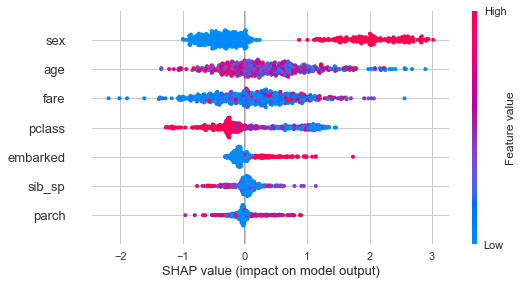

In [11]:
shap.summary_plot(shap_values, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


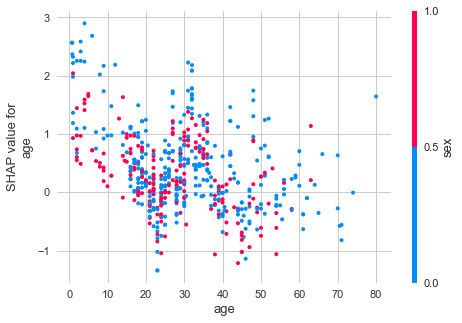

In [12]:
shap.dependence_plot("age", shap_values, X_train)

In [13]:
shap.initjs()

In [14]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [15]:
shap.force_plot(explainer.expected_value, shap_values, X_train)